In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=1
cpu=6
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))

def create_base_train_data(x,y,i):
    smote_x,smote_y=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x,y)
    selector=SelectKBest(score_func=f_classif,k=i).fit(smote_x,smote_y)
    x_select=selector.transform(smote_x)
    select_features=selector.get_support(1)
    new_x=PolynomialFeatures(degree=2).fit_transform(x_select)
    return new_x,smote_y,select_features

def create_base_test_data(x,feature):
    new_x=x[x.columns[feature]]
    new_x=PolynomialFeatures(degree=2).fit_transform(new_x)
    return new_x

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    return f1,auc_score
    
def baseDataSet(GodClassFile):
    df=pd.read_csv(GodClassFile,encoding_errors="replace")
    df=df[["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","GodClass"]]
    df=df.dropna(how="any")
    return df

def addMetricsDataSet(GodClassFile):
    df=pd.read_csv(GodClassFile,encoding_errors="replace")
    df=df[["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","tcc_x","NprotM_x","BOvR_x","ATFD_x","ATLD_x","LAA_x","BUR_x","FDP_x","GodClass"]]
    df=df.dropna(how="any")
    return df

def addOldVersionDataSet(GodClassFile):
    df=pd.read_csv(GodClassFile,encoding_errors="replace")
    df=df[['dit_x', 'fanin_x', 'fanout_x', 'lcc_x', 'lcom*_x', 'loc_x', 'noc_x', 'rfc_x', 'innerClassesQty_x', 'totalFieldsQty_x', 'totalMethodsQty_x', 'wmc_x', 'tcc_x', 'NprotM_x', 'BOvR_x', 'ATFD_x', 'ATLD_x', 'LAA_x', 'BUR_x', 'FDP_x', 'dit_y', 'fanin_y', 'fanout_y', 'lcc_y', 'lcom*_y', 'loc_y', 'noc_y', 'rfc_y', 'innerClassesQty_y', 'totalFieldsQty_y', 'totalMethodsQty_y', 'wmc_y', 'tcc_y', 'NprotM_y', 'BOvR_y', 'ATFD_y', 'ATLD_y', 'LAA_y', 'BUR_y', 'FDP_y',"GodClass"]]
    df=df.dropna(how="any")
    return df

def normalization(df):
    for column in df.columns:
        df[column]=(df[column]-df[column].min())/(df[column].max()-df[column].min())
    return df

#オーバーサンプリング，多項式化データ
def create_train_test_data(x,y,i):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
    x_train_base,y_train_base,features=create_base_train_data(x_train,y_train,i)
    x_test_base=create_base_test_data(x_test,features)
    return x_train_base,y_train_base,x_test_base,y_test,features

def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

In [ ]:
GodClassFile=os.path.join(datasetFolder,"dataset2\\GodClass.csv")
baseDF=baseDataSet(GodClassFile)
x_base=baseDF.drop(columns=["GodClass"])
y_base=baseDF[["GodClass"]].values.ravel()
x_base_train,x_base_test,y_base_train,y_base_test=train_test_split(x_base,y_base,test_size=0.2,random_state=SEED)
x_base_sampling,y_base_sampling=overSampling(x_base_train,y_base_train)
#x_train_base,y_train_base,x_test_base,y_test_base,features_base=create_train_test_data(x_base,y_base)

addMetricsDF=addMetricsDataSet(GodClassFile)
x_add=addMetricsDF.drop(columns=["GodClass"])
y_add=addMetricsDF[["GodClass"]].values.ravel()
x_add_train,x_add_test,y_add_train,y_add_test=train_test_split(x_add,y_add,test_size=0.2,random_state=SEED)
x_add_sampling,y_add_sampling=overSampling(x_add_train,y_add_train)
#x_train_add,y_train_add,x_test_add,y_test_add,features_add=create_train_test_data(x_add,y_add)



In [ ]:
name="DT"
DT_prameter={
    "classifier__criterion":["gini","entropy"],
    "classifier__max_depth":list(range(1,11)),
    "classifier__min_samples_split":list(range(2,21)),
    "classifier__min_samples_leaf":list(range(1,11)),
    "classifier__max_features":["sqrt","log2",None]
    }

k_range=np.arange(1,11,1)
f1_baselist=[]
auc_baselist=[]
features_baselist=[]
f1_addlist=[]
auc_addlist=[]
features_addlist=[]
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",DecisionTreeClassifier(random_state=SEED))
    ])
    DT_model=RandomizedSearchCV(pipline, param_distributions=DT_prameter,cv=KFold(n_splits=10),random_state=SEED,n_iter=cpu)

    print(str(i))
    f1_base,auc_score_base=predict_score(DT_model,x_base_sampling,y_base_sampling,x_base_test,y_base_test,name)
    f1_baselist.append(f1_base)
    auc_baselist.append(auc_score_base)
    
    f1_add,auc_score_add=predict_score(DT_model,x_add_sampling,y_add_sampling,x_add_test,y_add_test,name)
    f1_addlist.append(f1_add)
    auc_addlist.append(auc_score_add)
    #features_baselist.append(baseDF.columns[features_base])
    #features_addlist.append(addMetricsDF.columns[features_add])


base
f1 :  0.08403361344537816
auc_score :  0.6275663806958371
Index(['dit_x', 'fanin_x', 'fanout_x', 'rfc_x', 'wmc_x'], dtype='object')

addMetrics
f1 :  0.10569105691056911
auc_score :  0.6700273898182312
Index(['dit_x', 'fanout_x', 'rfc_x', 'BOvR_x', 'BUR_x'], dtype='object')

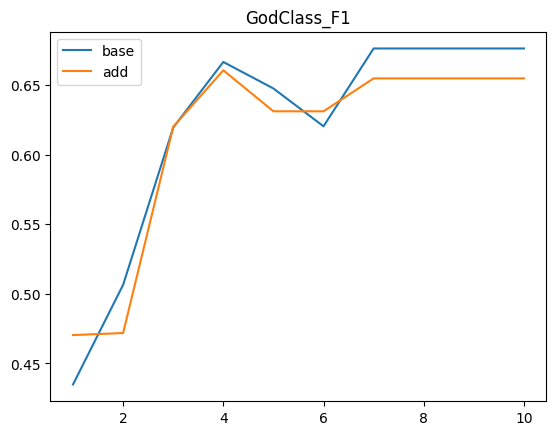

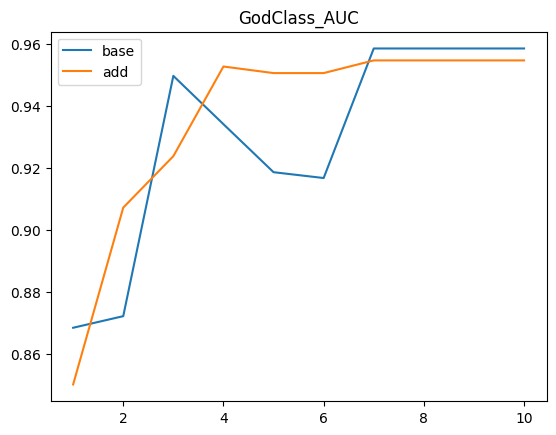

In [10]:
import matplotlib.pyplot as plt

x=k_range
plt.title("GodClass_F1")
plt.plot(x,f1_baselist,label="base")
plt.plot(x,f1_addlist,label="add")
plt.legend()
plt.show()

plt.title("GodClass_AUC")
plt.plot(x,auc_baselist,label="base")
plt.plot(x,auc_addlist,label="add")
plt.legend()
plt.show()